#### import libraries


In [1]:
import warnings
from tqdm import tqdm
from typing import Union

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### set pandas options for display
np.random.seed(123)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)


In [3]:
from shap import TreeExplainer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from pycaret.datasets import get_data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

In [4]:
df = get_data("gold", verbose=False)
df *= 100

df.columns = [c.replace(' ', '_')for c in df.columns]

target = "Gold_T+22"

features = [f for f in df.columns if f != target]
argsort = np.argsort([ 
                      f.split("T-")[0] + "T-" + "{:2.1f}".format(float(f.split("T-")[1])).zfill(4) 
                      for f in features
                    ])
features = [features[arg] for arg in argsort]

In [5]:
y = df[target]
X = df[features]
X.shape, y.shape

((2558, 120), (2558,))

#### utility functions

In [6]:
def get_prediction_and_shap(X:pd.DataFrame, features:list, y:Union[pd.Series, list, np.ndarray]):
    X_choosen_features = X.loc[:, features]
    # model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42).fit(X_choosen_features, y)
    model = LGBMRegressor(verbosity=-1).fit(X_choosen_features, y)
    prediction = pd.Series(model.predict(X_choosen_features), index=X_choosen_features.index)
    return model, prediction  

In [7]:
def get_feature_contribution(model, X, features, y):
    
    shap_explainer = TreeExplainer(model)
    shap_values = pd.DataFrame(
        data=shap_explainer.shap_values(X.loc[:, features]),
        index=X.index,
        columns=features
    )
    
    prediction_contribution = shap_values.abs().mean().rename('prediction_contribution')
    y_pred = model.predict(X.loc[:, features])
    abs_error = (y - y_pred).abs()
    
    y_pred_wo_feature = shap_values.apply(lambda feature: y_pred - feature)
    abs_error_wo_feature = y_pred_wo_feature.apply(lambda feature: (y - feature).abs())
    error_difference = abs_error_wo_feature.apply(lambda feature: abs_error - feature)
    error_contribution = error_difference.mean().rename('error_contribution')
    
    return prediction_contribution, error_contribution

In [8]:
def get_rfe_prediction_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, features):
    rfe_predition_contribution = pd.DataFrame(dtype=np.float64)
    current_feature = features.copy()


    for i in tqdm(range(len(features))):
        model, pred = get_prediction_and_shap(X_train, current_feature, y_train)
        pred_contrib, err_contrib = get_feature_contribution(model, X_valid, current_feature, y_valid)
        
        rfe_predition_contribution.loc[i, 'features'] = ','.join(current_feature)
        rfe_predition_contribution.loc[i, 'n_features'] = len(current_feature)
        rfe_predition_contribution.loc[i, 'contrib'] = pred_contrib.min()
        rfe_predition_contribution.loc[i, 'mae_train'] = mean_absolute_error(y_train, model.predict(X_train.loc[:, current_feature]))
        rfe_predition_contribution.loc[i, 'mae_valid'] = mean_absolute_error(y_valid, model.predict(X_valid.loc[:, current_feature]))
        rfe_predition_contribution.loc[i, 'mae_test'] = mean_absolute_error(y_test, model.predict(X_test.loc[:, current_feature]))
        rfe_predition_contribution.loc[i, 'r2_train'] = r2_score(y_train, model.predict(X_train.loc[:, current_feature]))
        rfe_predition_contribution.loc[i, 'r2_valid'] = r2_score(y_valid, model.predict(X_valid.loc[:, current_feature]))
        rfe_predition_contribution.loc[i, 'r2_test'] = r2_score(y_test, model.predict(X_test.loc[:, current_feature]))
        
        feature_to_remove = pred_contrib.idxmin()
        current_feature.remove(feature_to_remove)
    
    return rfe_predition_contribution

In [9]:
def get_rfe_error_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, features):
    rfe_error_contribution = pd.DataFrame(dtype=np.float64)
    current_feature = features.copy()


    for i in tqdm(range(len(features))):
        model, pred = get_prediction_and_shap(X_train, current_feature, y_train)
        pred_contrib, err_contrib = get_feature_contribution(model, X_valid, current_feature, y_valid)
        
        rfe_error_contribution.loc[i, 'features'] = ','.join(current_feature)
        rfe_error_contribution.loc[i, 'n_features'] = len(current_feature)
        rfe_error_contribution.loc[i, 'contrib'] = err_contrib.max()
        rfe_error_contribution.loc[i, 'mae_train'] = mean_absolute_error(y_train, model.predict(X_train.loc[:, current_feature]))
        rfe_error_contribution.loc[i, 'mae_valid'] = mean_absolute_error(y_valid, model.predict(X_valid.loc[:, current_feature]))
        rfe_error_contribution.loc[i, 'mae_test'] = mean_absolute_error(y_test, model.predict(X_test.loc[:, current_feature]))
        rfe_error_contribution.loc[i, 'r2_train'] = r2_score(y_train, model.predict(X_train.loc[:, current_feature]))
        rfe_error_contribution.loc[i, 'r2_valid'] = r2_score(y_valid, model.predict(X_valid.loc[:, current_feature]))
        rfe_error_contribution.loc[i, 'r2_test'] = r2_score(y_test, model.predict(X_test.loc[:, current_feature]))
        
        feature_to_remove = err_contrib.idxmax()
        current_feature.remove(feature_to_remove)
        
    return rfe_error_contribution

In [10]:
def plot_graph(rfe_predition_contribution, rfe_error_contribution, metrics='mae',  y_label='MAE', x_label='N Features', title='MEA' ):
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(rfe_predition_contribution.n_features, rfe_predition_contribution.loc[:,f'{metrics}_train'], label='Prediction Contribution', color='blue')
    plt.plot(rfe_error_contribution.n_features, rfe_error_contribution.loc[:,f'{metrics}_train'], label='Error Contribution', color='orange')
    plt.title(f'{title} on train data')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.subplot(1,3,2)
    plt.plot(rfe_predition_contribution.n_features, rfe_predition_contribution.loc[:,f'{metrics}_valid'], label='Prediction Contribution', color='blue')
    plt.plot(rfe_error_contribution.n_features, rfe_error_contribution.loc[:,f'{metrics}_valid'], label='Error Contribution', color='orange')
    plt.title(f'{title} on Valid data')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.subplot(1,3,3)
    plt.plot(rfe_predition_contribution.n_features, rfe_predition_contribution.loc[:,f'{metrics}_test'], label='Prediction Contribution', color='blue')
    plt.plot(rfe_error_contribution.n_features, rfe_error_contribution.loc[:,f'{metrics}_test'], label='Error Contribution', color='orange')
    plt.title(f'{title} on test data')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend()

#### Actual Data

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.66, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=123)

100%|██████████| 120/120 [02:07<00:00,  1.07s/it]


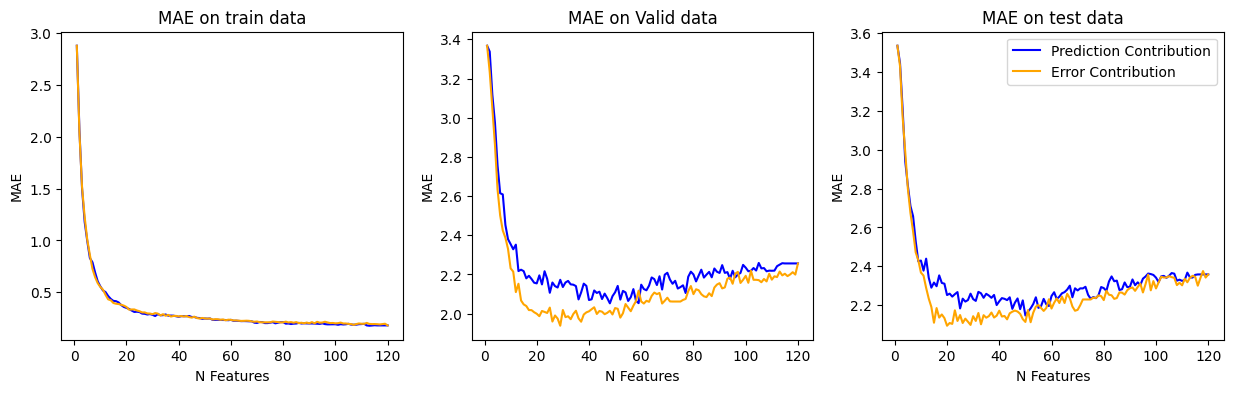

In [12]:
rfe_predition_contribution = get_rfe_prediction_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, features)
rfe_error_contribution = get_rfe_error_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, features)
plot_graph(rfe_predition_contribution, rfe_error_contribution, metrics='mae', y_label='MAE', x_label='N Features', title='MAE')

#### Add randomness in data

In [13]:
X_ = X + np.random.rand(X.shape[0], X.shape[1]) * 10   # some random value added to X

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_, y, test_size=0.66, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=123)

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [02:32<00:00,  1.27s/it]


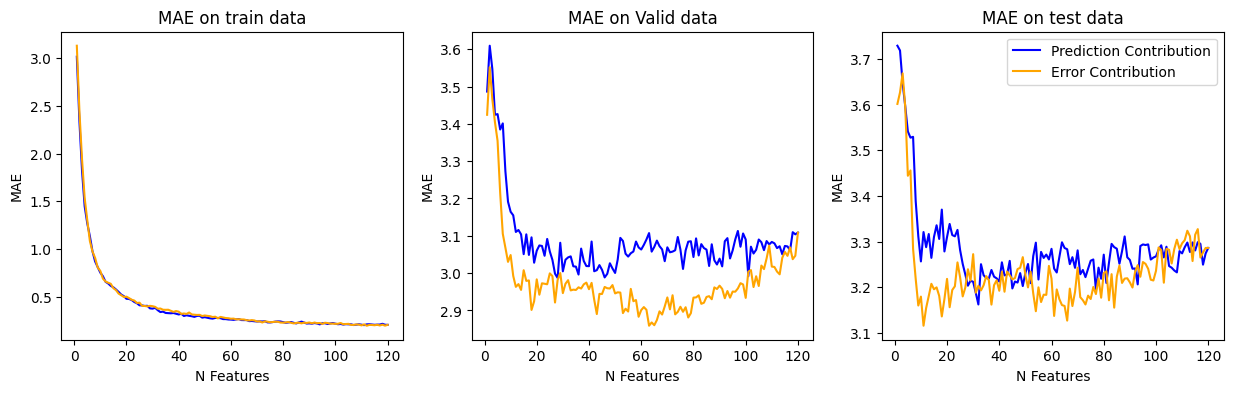

In [15]:
rfe_predition_contribution = get_rfe_prediction_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, features)
rfe_error_contribution = get_rfe_error_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, features)
plot_graph(rfe_predition_contribution, rfe_error_contribution, metrics='mae', y_label='MAE', x_label='N Features', title='MAE')

#### Change the random state on train test creation.

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.66, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

100%|██████████| 120/120 [03:39<00:00,  1.83s/it]


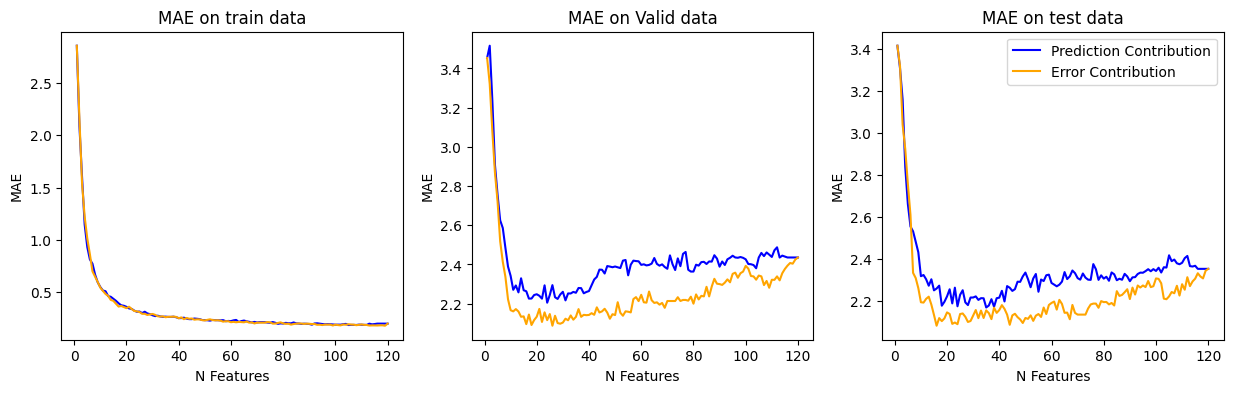

In [17]:
rfe_predition_contribution = get_rfe_prediction_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, features)
rfe_error_contribution = get_rfe_error_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, features)
plot_graph(rfe_predition_contribution, rfe_error_contribution, metrics='mae', y_label='MAE', x_label='N Features', title='MAE')

#### Change the train test size

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [03:27<00:00,  1.73s/it]


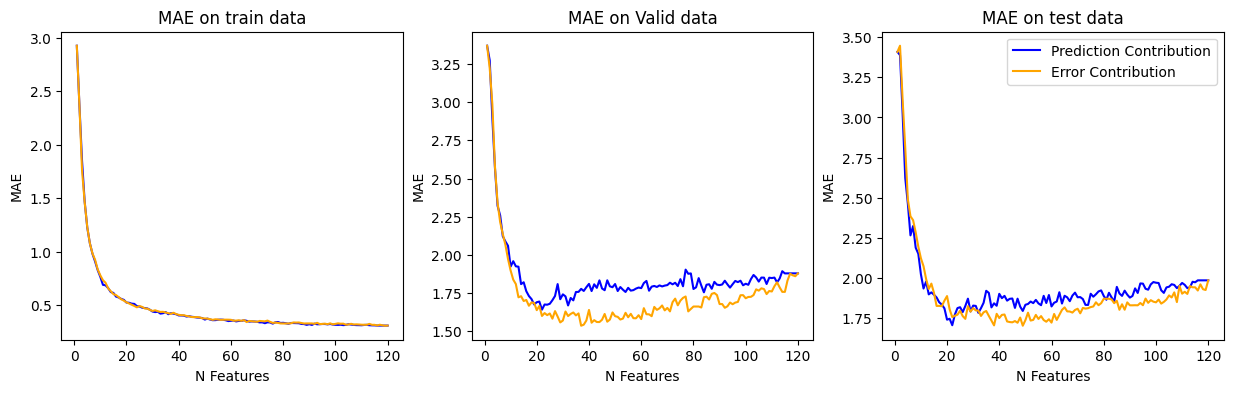

In [19]:
rfe_predition_contribution = get_rfe_prediction_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, features)
rfe_error_contribution = get_rfe_error_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, features)
plot_graph(rfe_predition_contribution, rfe_error_contribution, metrics='mae', y_label='MAE', x_label='N Features', title='MAE')

#### simulating categorical features one hot encoded

In [20]:
cat_encoded = pd.get_dummies(np.random.choice(range(1,50), size=X.shape[0]))
col_names = X.columns.values.tolist().copy()
col_names.extend([ f'cat_col_{i}'for i in range(1,50)])
X_ = pd.DataFrame( data = np.hstack((X, cat_encoded)), index=X.index, columns = col_names)


In [21]:

X_train, X_valid, y_train, y_valid = train_test_split(X_, y, test_size=0.66, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=123)

In [22]:
X_train.shape

(869, 169)

100%|██████████| 169/169 [06:34<00:00,  2.33s/it]


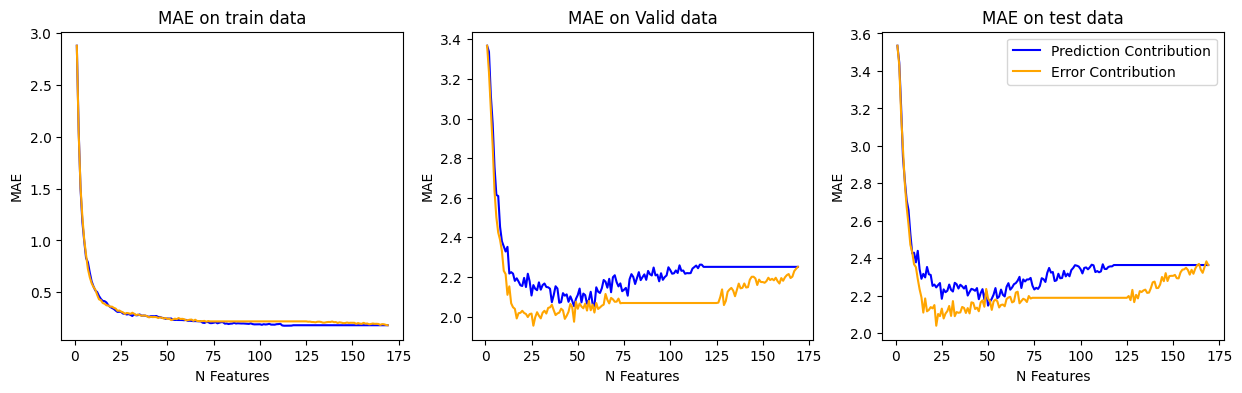

In [23]:
rfe_predition_contribution = get_rfe_prediction_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, col_names)
rfe_error_contribution = get_rfe_error_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, col_names)
plot_graph(rfe_predition_contribution, rfe_error_contribution, metrics='mae', y_label='MAE', x_label='N Features', title='MAE')

##### Changing the test and train size

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X_, y, test_size=0.4, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=123)

100%|██████████| 169/169 [05:31<00:00,  1.96s/it]


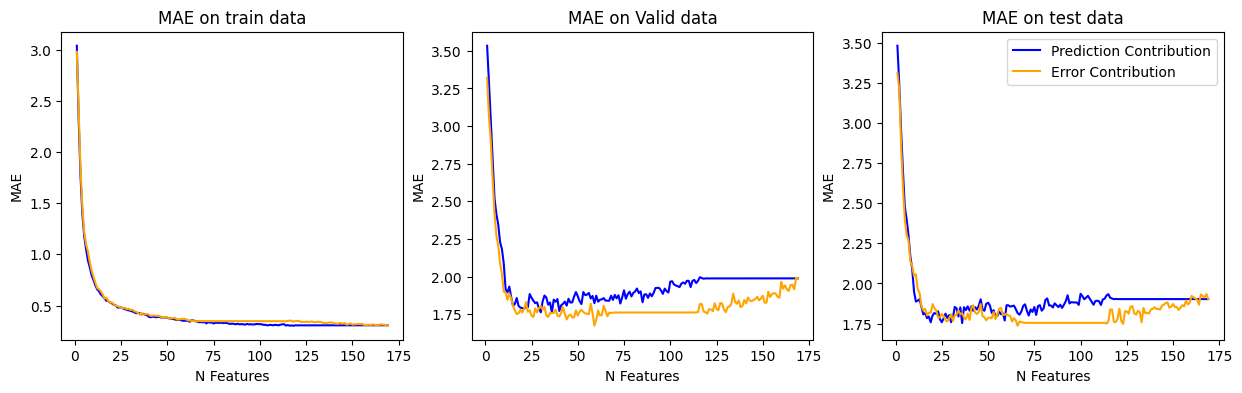

In [25]:
rfe_predition_contribution = get_rfe_prediction_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, col_names)
rfe_error_contribution = get_rfe_error_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, col_names)
plot_graph(rfe_predition_contribution, rfe_error_contribution, metrics='mae', y_label='MAE', x_label='N Features', title='MAE')

#### Trying on bike data

In [26]:
df = get_data('bike')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1/1/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,1/1/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,1/1/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,1/1/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,1/1/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1/1/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,1/1/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,1/1/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,1/1/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,1/1/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.0+ MB


In [28]:
# train_data_filt = df.dteday < '2012-01-01'
# valid_data_filt = (df.dteday >= '2011-09-01') & (df.dteday < '2012-05-01')
# test_data_filt = df.dteday >= '2012-05-01'


# df_train = df[train_data_filt]
# df_valid = df[valid_data_filt]
# df_test = df[test_data_filt]


# X_train = df_train.drop(columns=['cnt', 'dteday'])
# y_train = df_train['cnt']

# X_valid = df_valid.drop(columns=['cnt', 'dteday'])
# y_valid = df_valid['cnt']

# X_test = df_test.drop(columns=['cnt', 'dteday'])
# y_test = df_test['cnt']

In [29]:
X = df.drop(columns=['yr', 'dteday'])
y = df['cnt']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=123, stratify=X.mnth)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=123, stratify=X_valid.mnth)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:14<00:00,  1.10s/it]


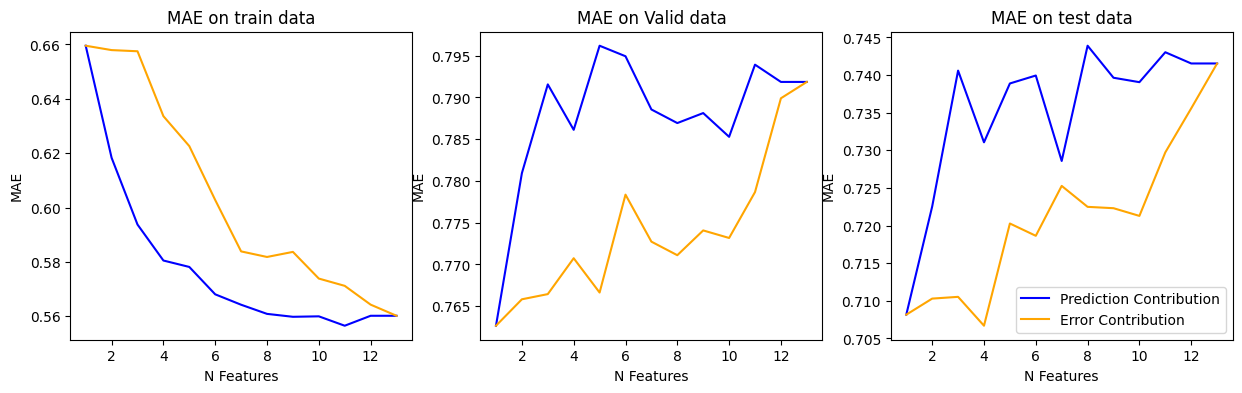

In [30]:
rfe_predition_contribution = get_rfe_prediction_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, X_train.columns.values.tolist())
rfe_error_contribution = get_rfe_error_contribution(X_train, X_valid, X_test, y_train, y_valid, y_test, X_train.columns.values.tolist())
plot_graph(rfe_predition_contribution, rfe_error_contribution, metrics='mae', y_label='MAE', x_label='N Features', title='MAE')

#### Trying in car data

In [31]:
df = pd.read_csv('CarPrice_Assignment.csv')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [33]:
cat_col_name = ['fueltype', 'enginelocation', 'fuelsystem', 'doornumber', 'carbody', 'drivewheel',  'aspiration', 'enginetype', 'CarName', 'cylindernumber']
num_col_name = X_train.describe().columns.to_list()

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder

In [35]:
X = df.drop(columns=['car_ID', 'price'])
y = df['price']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=123)

##### Transforming categorical column using One Hot

In [36]:
cat_col_transformer = Pipeline(steps=[
    ('cat_col_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

data_prep_pipe = Pipeline(steps=[
    ('column_processor', ColumnTransformer(
        transformers=[
            ('cat_col_transformer', cat_col_transformer, cat_col_name),
        ],
        remainder='passthrough',
    )),
])

In [37]:
X_train_processed = data_prep_pipe.fit_transform(X_train)
X_valid_processed = data_prep_pipe.transform(X_valid)
X_test_processed = data_prep_pipe.transform(X_test)

In [38]:
X_train_processed = pd.DataFrame(X_train_processed, columns=data_prep_pipe.get_feature_names_out())
X_valid_processed = pd.DataFrame(X_valid_processed, columns=data_prep_pipe.get_feature_names_out())
X_test_processed = pd.DataFrame(X_test_processed, columns=data_prep_pipe.get_feature_names_out())

100%|██████████| 152/152 [00:29<00:00,  5.20it/s]


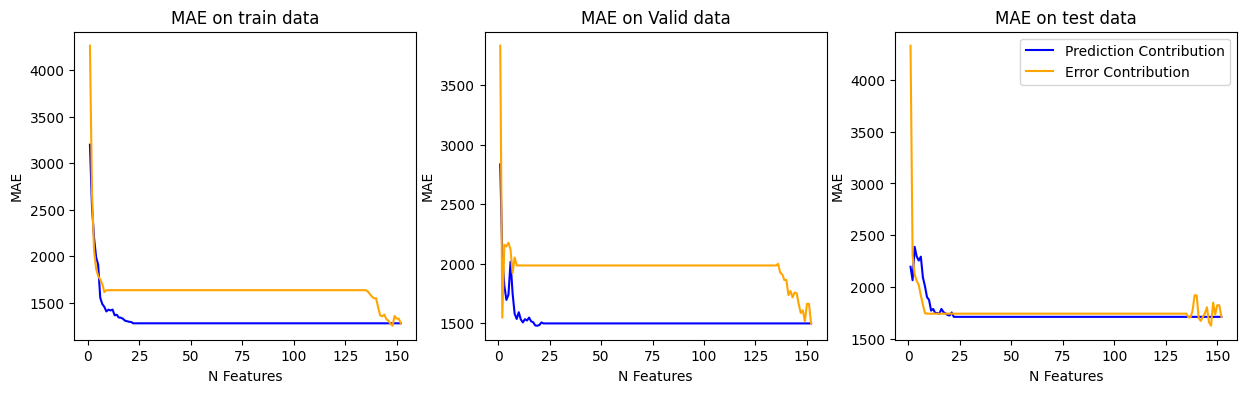

In [39]:
rfe_predition_contribution = get_rfe_prediction_contribution(X_train_processed, X_valid_processed, X_test_processed, y_train, y_valid, y_test, X_train_processed.columns.values.tolist())
rfe_error_contribution = get_rfe_error_contribution(X_train_processed, X_valid_processed, X_test_processed, y_train, y_valid, y_test, X_train_processed.columns.values.tolist())
plot_graph(rfe_predition_contribution, rfe_error_contribution, metrics='mae', y_label='MAE', x_label='N Features', title='MAE')

##### Transforming categorical column using Ordinal Transformation (Though there is no order in categories )

In [40]:
cat_col_transformer_1 = Pipeline(steps=[
    ('ord_col_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
])

data_prep_pipe_1 = Pipeline(steps=[
    ('column_processor', ColumnTransformer(
        transformers=[
            ('cat_col_transformer', cat_col_transformer_1, cat_col_name),
        ],
        remainder='passthrough',
    )),
])

In [41]:
X_train_processed = pd.DataFrame(data_prep_pipe_1.fit_transform(X_train), columns=X_train.columns)
X_valid_processed = pd.DataFrame(data_prep_pipe_1.fit_transform(X_valid), columns=X_valid.columns)
X_test_processed = pd.DataFrame(data_prep_pipe_1.fit_transform(X_test), columns=X_test.columns)

100%|██████████| 24/24 [00:01<00:00, 12.62it/s]


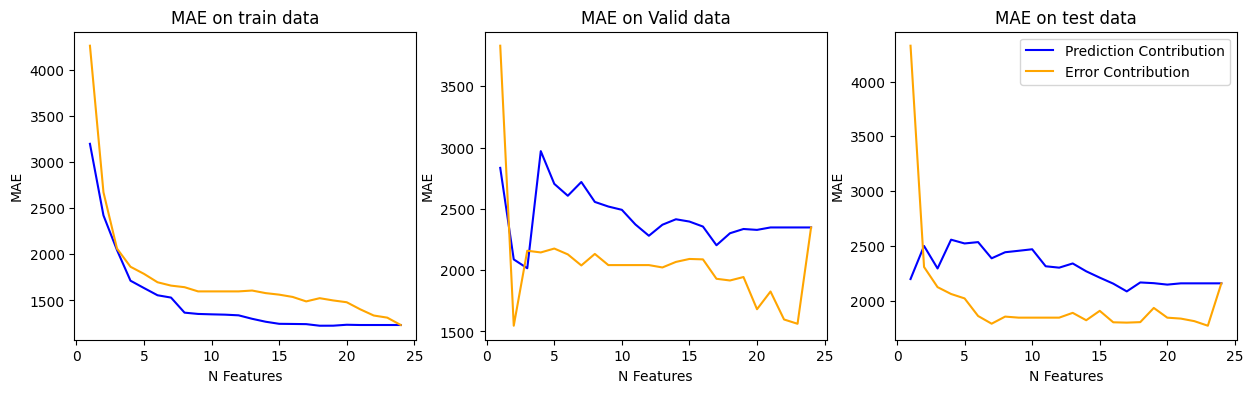

In [42]:
rfe_predition_contribution = get_rfe_prediction_contribution(X_train_processed, X_valid_processed, X_test_processed, y_train, y_valid, y_test, X_train_processed.columns.values.tolist())
rfe_error_contribution = get_rfe_error_contribution(X_train_processed, X_valid_processed, X_test_processed, y_train, y_valid, y_test, X_train_processed.columns.values.tolist())
plot_graph(rfe_predition_contribution, rfe_error_contribution, metrics='mae', y_label='MAE', x_label='N Features', title='MAE')

#### Trying on housing data

In [ ]:
df = get_data('house')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,...,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,...,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,...,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,...,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
num_cols = df.describe().columns.to_list()
cat_cols = list(set(df.columns) - set(num_cols))

In [63]:
cat_col_transformer_2 = Pipeline(steps=[
    ('ord_col_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
])

data_prep_pipe_2 = Pipeline(steps=[
    ('column_processor', ColumnTransformer(
        transformers=[
            ('cat_col_transformer', cat_col_transformer_2, cat_cols),
        ],
        remainder='passthrough',
    )),
])

In [64]:
X = df.drop(columns=['Id', 'SalePrice'])
y = df.SalePrice
X.shape, y.shape

((1460, 79), (1460,))

In [65]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=123)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=123)

In [66]:
X_train_processed = pd.DataFrame(data_prep_pipe_2.fit_transform(X_train), columns=X_train.columns)
X_valid_processed = pd.DataFrame(data_prep_pipe_2.fit_transform(X_valid), columns=X_valid.columns)
X_test_processed = pd.DataFrame(data_prep_pipe_2.fit_transform(X_test), columns=X_test.columns)

In [67]:
X_train_processed.shape

(876, 79)

100%|██████████| 79/79 [00:26<00:00,  3.01it/s]


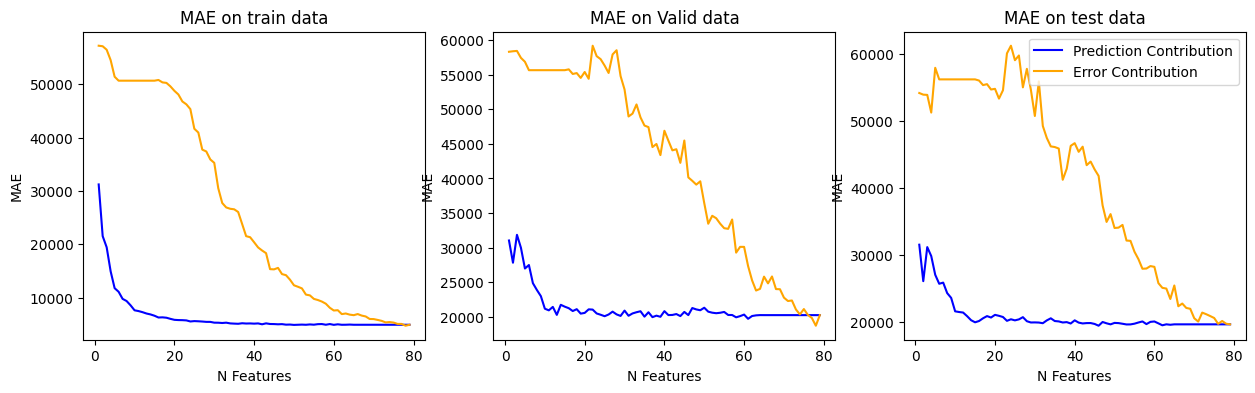

In [68]:
rfe_predition_contribution = get_rfe_prediction_contribution(X_train_processed, X_valid_processed, X_test_processed, y_train, y_valid, y_test, X_train_processed.columns.values.tolist())
rfe_error_contribution = get_rfe_error_contribution(X_train_processed, X_valid_processed, X_test_processed, y_train, y_valid, y_test, X_train_processed.columns.values.tolist())
plot_graph(rfe_predition_contribution, rfe_error_contribution, metrics='mae', y_label='MAE', x_label='N Features', title='MAE')